# Lab04-1 - Perceptron, Adaline, and Optimization

## Lab04-1_109021115 Chia-Chun Wu

In [2]:
# inline plotting instead of popping out
%matplotlib inline

import os, math
from IPython.display import Image
import numpy as np
seed = np.random.seed

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 80
# Testing data points: 20
Class labels: [-1  1]


## Handcrafted Adaline classifier with M as parameter

In [4]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier with mini-batch functionality."""
    
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, M=1):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.M = M  # Mini-batch size
        self.w_initialized = False
        if random_state:
            np.random.seed(random_state)
        
    def fit(self, X, y):
        """Fit training data."""
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for X_batch, y_batch in self._generate_batches(X, y, self.M):
                cost.append(self._update_weights_batch(X_batch, y_batch))
            avg_cost = sum(cost) / len(cost)
            self.cost_.append(avg_cost)
        return self
    
    def _shuffle(self, X, y):
        """Shuffle training data."""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _generate_batches(self, X, y, batch_size):
        """Generate mini-batches of data."""
        for i in range(0, len(y), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            yield X_batch, y_batch
    
    def _initialize_weights(self, m):
        """Initialize weights."""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights_batch(self, X_batch, y_batch):
        """Update weights using a mini-batch."""
        output = self.activation(X_batch)
        errors = y_batch - output
        cost = 0.5 * np.mean(errors**2)
        
        self.w_[1:] += self.eta * X_batch.T.dot(errors)
        self.w_[0] += self.eta * errors.sum()
        
        return cost
    
    def net_input(self, X):
        """Calculate net input."""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation."""
        return self.net_input(X)
    
    def predict(self, X):
        """Return class label after unit step."""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing weights."""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for X_batch, y_batch in self._generate_batches(X, y, self.M):
                self._update_weights_batch(X_batch, y_batch)
        else:
            self._update_weights_batch(X, y)
        return self

## Model with 3 different batch size M and fixed learning rate η

For M = 1
Misclassified samples: 3
Accuracy: 0.85
For M = 32
Misclassified samples: 3
Accuracy: 0.85
For M = 64
Misclassified samples: 3
Accuracy: 0.85


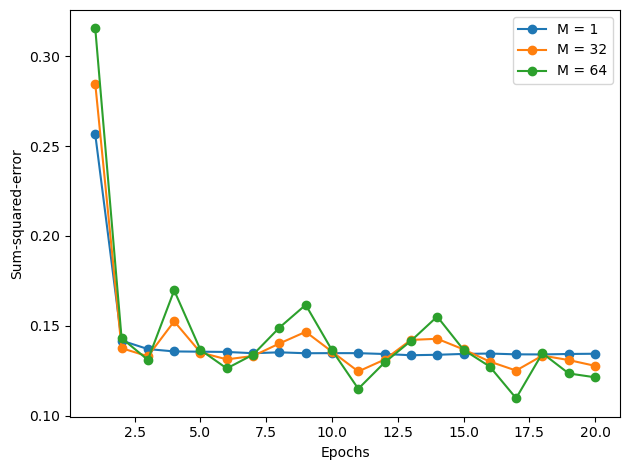

In [23]:
adas1 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, M=1)
adas1.fit(X_train_std, y_train)

adas2 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, M=32)
adas2.fit(X_train_std, y_train)

adas3 = AdalineSGD(n_iter=20, eta=0.01, random_state=1, M=64)
adas3.fit(X_train_std, y_train)

# Testing accuracy
y_pred = adas1.predict(X_test_std)
print('For M = 1')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

y_pred = adas2.predict(X_test_std)
print('For M = 32')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

y_pred = adas3.predict(X_test_std)
print('For M = 64')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# Cost values
plt.plot(range(1, len(adas1.cost_) + 1), adas1.cost_, 
         marker='o', label='M = 1')

plt.plot(range(1, len(adas2.cost_) + 1), adas2.cost_, 
         marker='o', label='M = 32')

plt.plot(range(1, len(adas3.cost_) + 1), adas3.cost_, 
         marker='o', label='M = 64')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()